In [2]:
import random
import collections
import pandas as pd 
import numpy as np
import networkx
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [3]:
fb_dir = "/Users/rezatabrizi/Downloads/facebook"

In [4]:
facebook_adj = pd.read_csv(os.path.join(fb_dir, "adj.txt"), sep = " ", header=None)
facebook_adj.columns = ['u', 'v']

In [12]:
class graph:
    def __init__(self, adj, directed, edge_weight="in_degree"):
        self.directed = directed
        self.edge_weight = edge_weight
        self._n = None
        self._m = None
        self.nodes = set()
        self.edges = collections.defaultdict(float)
        self.children = collections.defaultdict(set) 
        self.parents = collections.defaultdict(set)
        self._create_graph(adj)

    def _create_graph (self, adj):
        for idx, row in adj.iterrows():
            u = row.iloc[0] 
            v = row.iloc[1]

            self.nodes.add(u)
            self.nodes.add(v)

            self.edges[(u, v)] = 0.0
            if (not self.directed):
                self.edges[(v, u)] = 0.0

            self.parents[v].add(u)
            self.children[u].add(v)
            
            if (not self.directed):
                self.parents[u].add(v)
                self.children[v].add(u)


        for u, v in self.edges.keys():
            if self.edge_weight == "in_degree":
                self.edges[(u, v)] = 1.0 / len(self.parents[v])
            elif self.edge_weight == "normal":
                self.edges[(u, v)] = np.clip(np.random.normal(.02, .007), 0, 1)
                
        self._n = len(self.nodes)
        self._m = len(self.edges)

## Statistics and Data Visualization of the Underlying Graph
1. Histogram of the out degree of each node

In [13]:
graph_gaussian = graph(facebook_adj, False, 'normal')
graph_indeg = graph(facebook_adj, False, 'in_degree')

Text(0, 0.5, 'Number of Nodes')

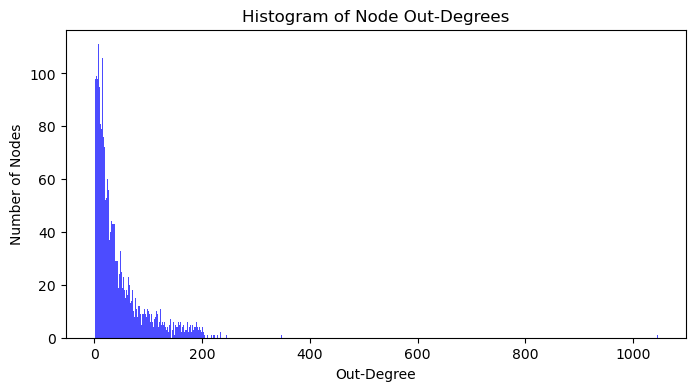

In [14]:
out_degrees = [len(graph_gaussian.children[n]) for n in range(graph_gaussian._n)]
plt.figure(figsize=(8, 4))
plt.hist(out_degrees, bins=range(max(out_degrees)+2), align='left', color='blue', alpha=0.7)
plt.title('Histogram of Node Out-Degrees')
plt.xlabel('Out-Degree')
plt.ylabel('Number of Nodes')


In [15]:
print (f"Average outdegree {sum(out_degrees)/len(out_degrees)}")

Average outdegree 43.69101262688784


In [9]:
def independent_cascade(graph, seed_set):
    can_activate_q = collections.deque()
    seed = set()
    
    for node in seed_set: 
        can_activate_q.append((node, 0))
    cascade = [] 

    while can_activate_q:
        u, u_t = can_activate_q.popleft() 
        if (u in seed):
            continue
        cascade.append((u, u_t))
        seed.add(u) 
        for v in graph.children[u]:
            chance = random.random()
            w = graph.edges[(u, v)]
            if v not in seed and chance <= w:
                can_activate_q.append((v, u_t+1))
    
    return cascade

In [10]:
def powerlaw_sample(min_value, max_value, exponent):
    """choose a number based on the power law distribution

    Args:
        min_value (int): min range
        max_value (int): max range
        exponent (int): power law exponent

    Returns:
        int: randomly chosen number based on he power law
    """
    y = (max_value**(exponent+1) - min_value**(exponent+1)) * random.random() + min_value**(exponent+1)
    return int(y**(1/(exponent+1)))

In [11]:
def generate_cascades(graph):
    seeds = []
    regression = []
    classification = []
    iters = 0
    while iters < 2000:
        seed_count = powerlaw_sample(1, graph._n, -2.5)
        seed_nodes = random.sample(range(graph._n), seed_count)
        seeds.append(seed_nodes)
    
        sum_activations = 0 
        sample = False
        i = 0
        while i < 1000:
            currrent_cascade = independent_cascade(graph, seed_nodes)
            if (not sample and len(currrent_cascade) >= 3):
                classification.append(currrent_cascade)
                sample = True
            sum_activations += len(currrent_cascade)
            i += 1
        regression.append(sum_activations/1000)
        iters += 1
    return seeds, regression, classification    

In [11]:
regression_cas_count = generate_cascades(graph_indeg)

In [12]:
seeds, regression_cascades, classification_cascades = regression_cas_count

In [13]:
classification_cascades[45]

[(1744, 0), (1645, 1), (1349, 2), (1878, 2), (1526, 3)]

In [14]:
def create_raw_classificaiton_data(classification_cascades): 
    with open ('raw_classification_facebook.txt', 'w') as file: 
        for i, cascade in enumerate(classification_cascades):
            file.write(f"{i} ")
            for node, t in cascade: 
                file.write(f"{node}:{t} ")
            file.write(f"\n")

def create_raw_regression_data(seed_set, regression_cascades):
    with open ('raw_regresssion_facebook.txt', 'w') as file:
        for i, activation_count in enumerate(regression_cascades):
            file.write(f"{i} ")
            for seed_node in seed_set[i]: 
                file.write(f"{seed_node} ")
            file.write(f"{activation_count}\n")

In [15]:
create_raw_classificaiton_data(classification_cascades)
create_raw_regression_data(seeds, regression_cascades)

(array([  0.,  71., 109., 109., 128., 129., 117.,  99.,  95.,  83.,  77.,
         67.,  67.,  79.,  64.,  61.,  61.,  52.,  28.,  36.,  32.,  24.,
         22.,  21.,  15.,  21.,  20.,  16.,  14.,  15.,  15.,  13.,  10.,
          6.,   8.,   6.,   5.,   6.,   9.,   6.,   7.,   9.,   7.,   1.,
          1.,   6.,  10.,   2.,   2.,   2.,   6.,   7.,   2.,   3.,  10.,
          2.,   1.,   2.,   1.,   2.,   5.,   5.,   1.,   4.,   4.,   1.,
          0.,   1.,   2.,   2.,   0.,   0.,   1.,   3.,   4.,   0.,   1.,
          0.,   0.,   5.,   2.,   3.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   1.,   0.,   3.,   3.,   0.,   2.,
          1.,   0.,   2.,   0.,   1.,   0.,   2.,   0.,   0.,   1.,   1.,
          0.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

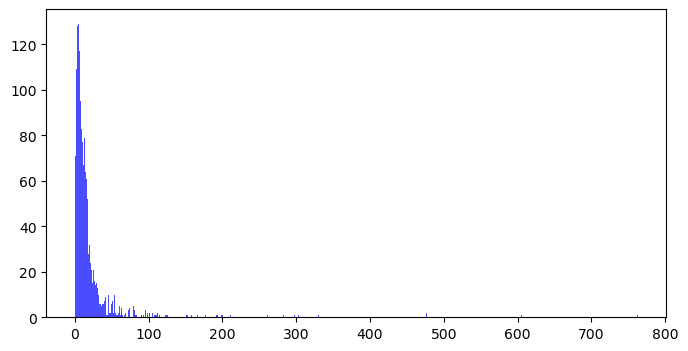

In [16]:
plt.figure(figsize=(8, 4))
plt.hist(regression_cascades, bins=range(int(max(regression_cascades))+2), align='left', color='blue', alpha=0.7)

In [16]:
import networkx as nx
edges = [list(row) for i, row in facebook_adj.iterrows()]
facebook_nx_g = nx.Graph()
facebook_nx_g.add_edges_from(edges)

In [20]:
def generate_static_centrality_features (graph):
    edges = [(u, v) for u,v in graph.edges.keys()]
    if (graph.directed):
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    
    G.add_edges_from(edges) 
    
    degree_centrality_facebook = nx.degree_centrality(G)
    eigenvector_centrality_facebook = nx.eigenvector_centrality(G)
    betweeness_centrality_facebook = nx.betweenness_centrality(G)

    with open ('static_node_centrality_facebook.txt', 'w') as file: 
        for node_idx in range(graph._n):
            file.write(f"{node_idx} {degree_centrality_facebook[node_idx]} {eigenvector_centrality_facebook[node_idx]} {betweeness_centrality_facebook[node_idx]}\n")

In [21]:
generate_static_centrality_features(graph_gaussian)

### Diameter of the graph

In [18]:
nx.diameter(facebook_nx_g)

8